In [27]:
import re
from pathlib import Path
import numpy as np
import pandas as pd

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
import torch
from torchtext.vocab import build_vocab_from_iterator
!pip install transformers
from transformers import BertTokenizer

In [30]:
from typing import Callable

In [31]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [32]:
from torch.utils.data import DataLoader, TensorDataset

In [33]:
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder

In [34]:
import torch.nn as nn
from transformers import BertModel

In [35]:
def simplify_text(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", ' ', s)

    # Replace all runs of whitespace with a single dash
    s = re.sub(r"\s+", '-', s)

    return s

In [36]:
dataset = Path("/kaggle/input/for-task") / "financial.json"


def read_dataset(threshold: int = 30, verbose: bool = False) -> pd.DataFrame:
    """
    Read the dataset from file and return it cleaned of null values/rows

    :param threshold: Minimum numbers of class representatives necessary for a class to be included in the final
                      dataset
    :return: filtered data (as pd.df)
    """
    # Read all data in a DataFrame
    data = pd.read_json(dataset)
    sub_data: pd.DataFrame = data["_source"].apply(pd.Series)
    data = pd.concat([data.drop(columns="_source"), sub_data], axis=1)
    if verbose:
        print(data.shape[0])

    # Keep only tickets that have a message description
    data["complaint_what_happened"] = data["complaint_what_happened"].map(lambda x: re.sub(r"XXXX|XX/XX/\d{4}", "", x))
    filtered_data = data[data["complaint_what_happened"].str.len() != 0]
    if verbose:
        print(filtered_data.shape[0])
    filtered_data = filtered_data[~filtered_data["complaint_what_happened"].isnull()]
    if verbose:
        print(filtered_data.shape[0])
        print(f"Average character number in ticket body: {filtered_data['complaint_what_happened'].str.len().mean():.2f}")

    # Find missing values in product and sub_product
    null_prods = filtered_data["product"].isnull().sum()
    null_subs = filtered_data["sub_product"].isnull().sum()
    if verbose:
        print(f"Nan values in 'product': {null_prods}")
        print(f"Nan values in 'sub_product': {null_subs}")

    # Fill missing sub_products fields with product values
    if verbose:
        print("Fixing missing values ...")
    filtered_data["sub_product"] = filtered_data["sub_product"].fillna(filtered_data["product"])

    null_prods = filtered_data["product"].isnull().sum()
    null_subs = filtered_data["sub_product"].isnull().sum()
    if verbose:
        print(f"Nan values in 'product': {null_prods}")
        print(f"Nan values in 'sub_product': {null_subs}")

    # Clean useless columns
    keep = ["complaint_what_happened", "product", "sub_product"]
    filtered_data = filtered_data.loc[:, keep]
    filtered_data.columns = ["message", "label", "sub_label"]

    # Delete duplicate rows
    filtered_data = filtered_data.drop_duplicates(subset=["message"], keep="first")
    filtered_data = filtered_data.dropna(axis=0)

    filtered_data.loc[:, "label"] = filtered_data["label"].map(simplify_text)
    filtered_data = filtered_data.dropna(axis=0)
    filtered_data.loc[:, "sub_label"] = filtered_data["sub_label"].map(simplify_text)
    filtered_data = filtered_data.dropna(axis=0)
    filtered_data["flattened_label"] = filtered_data["label"] + "_" + filtered_data["sub_label"]
    filtered_data = filtered_data.reset_index(drop=True)

    # Remove categories appearing < tot times
    c1 = filtered_data["label"].value_counts()
    filtered_data = filtered_data.replace(c1[c1 < threshold].index, np.nan).dropna(axis=0)
    c2 = filtered_data["sub_label"].value_counts()
    filtered_data = filtered_data.replace(c2[c2 < threshold].index, np.nan).dropna(axis=0)
    filtered_data = filtered_data.reset_index(drop=True)

    if verbose:
        print(f"Final dataset of size: {filtered_data.shape}")
        print(filtered_data.columns.to_series().to_string(index=False))
        print(filtered_data.isnull().sum(axis=0))
        print(filtered_data.shape[0])
    return filtered_data

In [37]:
read_financial = read_dataset()
read_financial.head()

,message,label,sub_label,flattened_label
0,Good morning my name is and I appreciate it ...,Debt-collection,Credit-card-debt,Debt-collection_Credit-card-debt
1,I upgraded my card in and was told by the a...,Credit-card-or-prepaid-card,General-purpose-credit-card-or-charge-card,Credit-card-or-prepaid-card_General-purpose-cr...
2,"Chase Card was reported on . However, fraudule...",Credit-reporting-credit-repair-services-or-oth...,Other-personal-consumer-report,Credit-reporting-credit-repair-services-or-oth...
3,"On , while trying to book a ticket, I came...",Credit-reporting-credit-repair-services-or-oth...,Credit-reporting,Credit-reporting-credit-repair-services-or-oth...
4,my grand son give me check for {$1600.00} i de...,Checking-or-savings-account,Checking-account,Checking-or-savings-account_Checking-account


In [38]:
num_classes = read_financial.label.nunique()
num_classes

14

In [39]:
class_mapping = {
    'Bank-account-or-service': 'Banking',
    'Checking-or-savings-account': 'Banking',
    'Consumer-Loan': 'Loans',
    'Credit-card': 'Credit',
    'Credit-card-or-prepaid-card': 'Credit',
    'Credit-reporting': 'Credit',
    'Credit-reporting-credit-repair-services-or-other-personal-consumer-reports': 'Credit',
    'Debt-collection': 'Debt',
    'Money-transfer-virtual-currency-or-money-service': 'Money',
    'Money-transfers': 'Money',
    'Mortgage': 'Loans',
    'Payday-loan-title-loan-or-personal-loan': 'Loans',
    'Student-loan': 'Loans',
    'Vehicle-loan-or-lease': 'Loans'
}

# Замена значений в столбце "label" с использованием словаря соответствий
read_financial['label'] = read_financial['label'].map(class_mapping)

# Вывод измененного датафрейма
read_financial.head()

,message,label,sub_label,flattened_label
0,Good morning my name is and I appreciate it ...,Debt,Credit-card-debt,Debt-collection_Credit-card-debt
1,I upgraded my card in and was told by the a...,Credit,General-purpose-credit-card-or-charge-card,Credit-card-or-prepaid-card_General-purpose-cr...
2,"Chase Card was reported on . However, fraudule...",Credit,Other-personal-consumer-report,Credit-reporting-credit-repair-services-or-oth...
3,"On , while trying to book a ticket, I came...",Credit,Credit-reporting,Credit-reporting-credit-repair-services-or-oth...
4,my grand son give me check for {$1600.00} i de...,Banking,Checking-account,Checking-or-savings-account_Checking-account


In [40]:
num_classes = read_financial.label.nunique()
num_classes

5

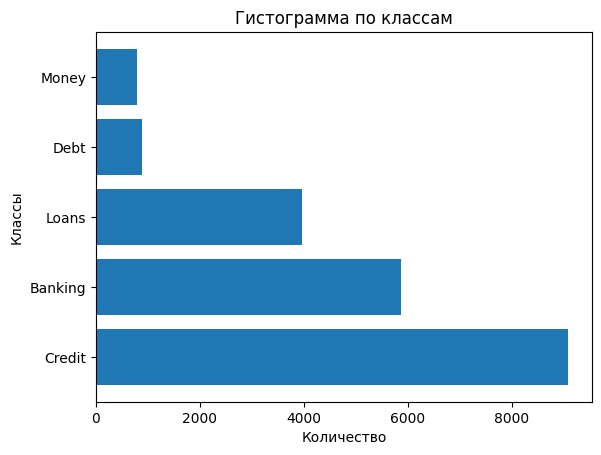

In [41]:
# Подсчет количества значений в каждом классе
class_counts = read_financial['label'].value_counts()

# Сортировка классов по количеству в убывающем порядке
class_counts = class_counts.sort_values(ascending=False)

# Построение упорядоченной горизонтальной гистограммы
plt.barh(class_counts.index, class_counts.values)
plt.xlabel('Количество')
plt.ylabel('Классы')
plt.title('Гистограмма по классам')
plt.show()



In [42]:
def regex_fun(regex: str, value: str) -> Callable:
    return lambda x: re.sub(regex, value, x)


# def remove_linux_garbage(data):
#     """
#     Taken from: https://arxiv.org/abs/1807.02892
#     Linux data contains lots of garbage, e.g. memory addresses - 0000f800
#     """

#     def is_garbage(w):
#         return len(w) >= 7 and sum(c.isdigit() for c in w) >= 2

#     data = data.map(lambda s: ' '.join(map(lambda w: w if not is_garbage(w) else ' ', s.split())))
#     return data


def text_cleanup(msg, remove_garbage: bool = False):
    msg = msg.map(regex_fun("\r", " "))
    msg = msg.map(regex_fun("\n", " "))
    # 2. Remove URLs
    msg = msg.map(regex_fun(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", ""))
    # 3. Remove Stack Trace
    # msg = msg.map(lambda s: (s + " ")[:s.find("Stack trace:")])  # WARN return -1 on failure
    # 4. Remove hex code
    msg = msg.map(regex_fun(r"(\w+)0x\w+", ""))
#     # 5. Remove linux garbage
#     if remove_garbage:
#         msg = remove_linux_garbage(msg)
    # 6. Change to lower case
    return msg.map(str.lower)

In [43]:
# как выглядит очищенный текст
text_cleanup(read_financial.message)

0        good morning my name is   and i appreciate it ...
1        i upgraded my   card in  and was told by the a...
2        chase card was reported on . however, fraudule...
3        on , while trying to book a     ticket, i came...
4        my grand son give me check for {$1600.00} i de...
                               ...                        
20585    my husband passed away. chase bank put check o...
20586    after being a chase card customer for well ove...
20587    on wednesday, xx/xx/ i called chas, my   visa ...
20588    i am not familiar with  pay and did not unders...
20589    i have had flawless credit for 30 yrs. i've ha...
Name: message, Length: 20590, dtype: object

In [44]:
def split_dataset(dataframe, test_size=0.2, max_length=128):
    # Инициализация токенизатора BERT
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    # Извлечение признаков и меток классов из датафрейма
    X = text_cleanup(dataframe["message"]).tolist()
    y = dataframe["label"].tolist()

    # Преобразование меток классов в числовые значения
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print (class_mapping)
    # Токенизация текстовых данных
    X_tokenized = tokenizer.batch_encode_plus(
        X, 
        add_special_tokens=True, # Добавление специальных токенов [CLS] и [SEP]
        max_length=max_length, # Ограничение длины входных данных
        padding='max_length', # Добавление паддинга до максимальной длины
        truncation=True, # Обрезание текста, если он превышает максимальную длину
        return_attention_mask=True, # Генерация маски внимания
        return_tensors='pt' # Возвращение данных в виде PyTorch тензоров
    )
    
    # Конвертация меток классов в тензор PyTorch
    y = torch.tensor(y)
    
    # Разбиение данных на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test, attention_train, attention_test, token_train, token_test = train_test_split(X_tokenized['input_ids'], y, X_tokenized['attention_mask'], X_tokenized['token_type_ids'], test_size=test_size, random_state=42)
        
    # Возвращение готовых для дообучения BERT данных
    return X_train, X_test, y_train, y_test, attention_train, attention_test, token_train, token_test


In [45]:
X_train, X_test, y_train, y_test, attention_train, attention_test, token_train, token_test = split_dataset(read_financial)

{'Banking': 0, 'Credit': 1, 'Debt': 2, 'Loans': 3, 'Money': 4}


In [47]:
# Создание датасетов PyTorch
train_dataset = TensorDataset(X_train, attention_train, token_train, y_train)
test_dataset = TensorDataset(X_test, attention_test, token_test, y_test)

# Создание DataLoader'ов для обучения и тестирования модели
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [43]:
class BertClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BertClassifier, self).__init__()

        self.bert1 = BertModel.from_pretrained('bert-base-uncased')
        self.bert1.requires_grad_(False)  # Замораживаем веса

        self.bert2 = BertModel.from_pretrained('bert-base-uncased')
        self.bert2.requires_grad_(False)  # Замораживаем веса

        self.fc = nn.Linear(self.bert1.config.hidden_size + self.bert2.config.hidden_size, num_classes)
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask, token_train):
        pooled_output1 = self.bert1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_train)[1]
        pooled_output2 = self.bert2(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_train)[1]

        combined_output = torch.cat((pooled_output1, pooled_output2), dim=1)
        combined_output = self.dropout(combined_output)

        logits = self.fc(combined_output)
        return logits


In [26]:
model = BertClassifier(num_classes=num_classes)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.pred

In [33]:
# Вычисление весов классов на основе их распределения в данных
class_counts = read_financial['label'].value_counts()
total_samples = len(read_financial)
class_weights = [total_samples / (class_counts[label] * len(class_counts)) for label in sorted(class_counts.keys())]

# Преобразование весов классов в тензор
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
class_weights_tensor = class_weights_tensor.to(device)
# Создание экземпляра функции потерь с учетом весов классов
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
class_weights

[0.7016527517464645,
 0.45342435586875135,
 4.621773288439955,
 1.0388496468213926,
 5.252551020408164]

In [52]:
# Установка вычислительного устройства для обучения модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

# model.to(device)

Using device: cuda
Tesla P100-PCIE-16GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [30]:
train_losses = []
test_losses = []

In [ ]:
# device = torch.device ("cpu")
# model.to(device)

In [36]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=1e-4)
epochs = 5
for epoch in range(epochs):
    print("Epoch: " + str(epoch))
    # Обучение модели на тренировочном наборе
    train_loss = 0.0
    model.train()
    for batch_idx, (input_ids, attention_mask, token_train, labels) in enumerate(train_loader):
        if batch_idx % 10 == 0:
          print("Batch: " + str(batch_idx))
        input_ids, attention_mask, token_train, labels = input_ids.to(device), attention_mask.to(device), token_train.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_train=token_train)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)    
    
    # Оценка модели на тестовом наборе
    test_loss = 0.0
    model.eval()
    with torch.no_grad():
        for batch_idx, (input_ids, attention_mask, token_test, labels) in enumerate(test_loader):
            input_ids, attention_mask, token_test, labels = input_ids.to(device), attention_mask.to(device), token_test.to(device), labels.to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_train = token_test)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    # Вывод информации о процессе обучения
    print('Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f}'.format(epoch+1, epochs, train_loss, test_loss))   

Epoch: 0
Batch: 0
Batch: 10
Batch: 20
Batch: 30
Batch: 40
Batch: 50
Batch: 60
Batch: 70
Batch: 80
Batch: 90
Batch: 100
Batch: 110
Batch: 120
Batch: 130
Batch: 140
Batch: 150
Batch: 160
Batch: 170
Batch: 180
Batch: 190
Batch: 200
Batch: 210
Batch: 220
Batch: 230
Batch: 240
Batch: 250
Epoch [1/12], Train Loss: 1.3174, Test Loss: 1.2763
Epoch: 1
Batch: 0
Batch: 10
Batch: 20
Batch: 30
Batch: 40
Batch: 50
Batch: 60
Batch: 70
Batch: 80
Batch: 90
Batch: 100
Batch: 110
Batch: 120
Batch: 130
Batch: 140
Batch: 150
Batch: 160
Batch: 170
Batch: 180
Batch: 190
Batch: 200
Batch: 210
Batch: 220
Batch: 230
Batch: 240
Batch: 250
Epoch [2/12], Train Loss: 1.3154, Test Loss: 1.2788
Epoch: 2
Batch: 0
Batch: 10
Batch: 20
Batch: 30
Batch: 40
Batch: 50
Batch: 60
Batch: 70
Batch: 80
Batch: 90
Batch: 100
Batch: 110
Batch: 120
Batch: 130
Batch: 140
Batch: 150
Batch: 160
Batch: 170
Batch: 180
Batch: 190
Batch: 200
Batch: 210
Batch: 220
Batch: 230
Batch: 240
Batch: 250
Epoch [3/12], Train Loss: 1.3093, Test Loss:

KeyboardInterrupt: 

In [49]:
model.dropout = nn.Dropout(0.7)
# layer1 = ['pooler.dense.', 'encoder.layer.11.', 'encoder.layer.10.', 'encoder.layer.9.']
pars1 = []
for name, param in model.bert2.named_parameters():
    pars1.append(param)
            
for name, param in model.bert1.named_parameters():
    pars1.append(param)
                
for param in pars1:
    param.requires_grad = True
    
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=1e-7)
epochs = 3
for epoch in range(epochs):
    print("Epoch: " + str(epoch))
    # Обучение модели на тренировочном наборе
    train_loss = 0.0
    model.train()
    for batch_idx, (input_ids, attention_mask, token_train, labels) in enumerate(train_loader):
        if batch_idx % 10 == 0:
          print("Batch: " + str(batch_idx))
        input_ids, attention_mask, token_train, labels = input_ids.to(device), attention_mask.to(device), token_train.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_train=token_train)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)    
    
    # Оценка модели на тестовом наборе
    test_loss = 0.0
    model.eval()
    with torch.no_grad():
        for batch_idx, (input_ids, attention_mask, token_test, labels) in enumerate(test_loader):
            input_ids, attention_mask, token_test, labels = input_ids.to(device), attention_mask.to(device), token_test.to(device), labels.to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_train = token_test)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    # Вывод информации о процессе обучения
    print('Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f}'.format(epoch+1, epochs, train_loss, test_loss))   
    
for param in pars1:
    param.requires_grad = False

Epoch: 0
Batch: 0
Batch: 10
Batch: 20
Batch: 30
Batch: 40
Batch: 50
Batch: 60
Batch: 70
Batch: 80
Batch: 90
Batch: 100
Batch: 110
Batch: 120
Batch: 130
Batch: 140
Batch: 150
Batch: 160
Batch: 170
Batch: 180
Batch: 190
Batch: 200
Batch: 210
Batch: 220
Batch: 230
Batch: 240
Batch: 250
Epoch [1/3], Train Loss: 0.5890, Test Loss: 0.6172
Epoch: 1
Batch: 0
Batch: 10
Batch: 20
Batch: 30
Batch: 40
Batch: 50
Batch: 60
Batch: 70
Batch: 80
Batch: 90
Batch: 100
Batch: 110
Batch: 120
Batch: 130
Batch: 140
Batch: 150
Batch: 160
Batch: 170
Batch: 180
Batch: 190
Batch: 200
Batch: 210
Batch: 220
Batch: 230
Batch: 240
Batch: 250
Epoch [2/3], Train Loss: 0.5821, Test Loss: 0.6187
Epoch: 2
Batch: 0
Batch: 10
Batch: 20
Batch: 30


KeyboardInterrupt: 

In [ ]:
for name, param in model.bert1.named_parameters():
    if param.requires_grad == False:
        print(name)

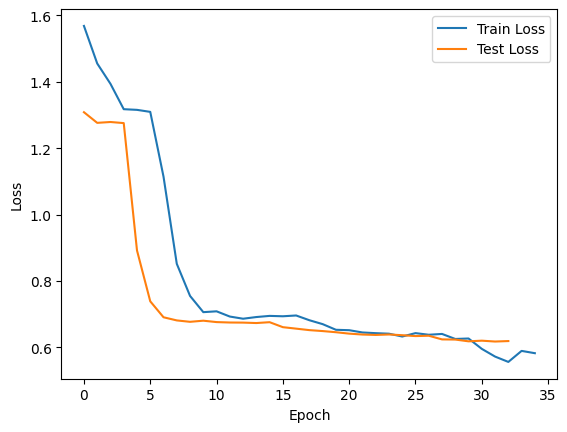

In [50]:
# Построение графика изменения значения функции потерь в процессе обучения
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [54]:
import onnxruntime as rt
import numpy as np

# Создание сессии ONNX Runtime с указанием использования GPU
session = rt.InferenceSession('/kaggle/input/mybertonnx/bert_model.onnx', providers=['CUDAExecutionProvider'])

# Вычисление метрик на тестовом наборе данных
y_pred = []
y_true = []
for batch_idx, (input_ids, attention_mask, token_test, labels) in enumerate(test_loader):
    batch_size = input_ids.size(0)
    print (batch_idx)
    for i in range(batch_size):
        # Извлечение текущего элемента из батча
        input_ids_single = input_ids[i:i+1]
        attention_mask_single = attention_mask[i:i+1]
        token_test_single = token_test[i:i+1]
        labels_single = labels[i:i+1]

        # Преобразование входных данных в формат ONNX
        input_data = {'input.1': input_ids_single.numpy(), 'attention_mask': attention_mask_single.numpy(), 'input.3': token_test_single.numpy()}

        # Вычисление предсказаний модели
        outputs = session.run(None, input_data)

        # Получение предсказанных меток классов
        predicted = np.argmax(outputs[0], axis=1)
        y_pred.extend(predicted)
        y_true.extend(labels_single.numpy())

# Вычисление и вывод метрик классификации
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
              precision    recall  f1-score   support

           0       0.86      0.77      0.81      1201
           1       0.92      0.79      0.85      1799
           2       0.38      0.64      0.48       183
           3       0.82      0.92      0.87       788
           4       0.39      0.82      0.53       147

    accuracy                           0.80      4118
   macro avg       0.68      0.79      0.71      4118
weighted avg       0.84      0.80      0.82      4118



In [52]:
torch.save(model.state_dict(), 'model_state_dict1.pth')

In [49]:
# !pip install onnx
# локально
model = BertClassifier(num_classes=num_classes)
model.load_state_dict(torch.load('model_state_dict1.pth'))

dummy_input_ids = torch.zeros((1, 128), dtype=torch.long)
dummy_attention_mask = torch.zeros((1, 128), dtype=torch.long)
dummy_token_id = torch.zeros((1, 128), dtype=torch.long)
torch.onnx.export(
    model,
    (dummy_input_ids, dummy_attention_mask, dummy_token_id),
    'bert_new.onnx',
    opset_version=11
)

NameError: name 'BertClassifier' is not defined

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 54.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.7 MB/s eta 0:00:00


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.